In [1]:
using PyPlot

# New Penalty Inspired by Huber Penalty
$$\rho(r;[\kappa,\sigma]) = 
\begin{cases}
\frac{2\kappa}{\sigma(\kappa^2+1)}(|r|-\kappa\sigma) + \log(1+\kappa^2),&|r| > \kappa\sigma\\
\log(1+x^2/\sigma^2),&|r| \le \kappa\sigma
\end{cases}$$

In [2]:
function ρ(r,θ)
    κ = θ[1]
    σ = θ[2]
    κ ≤ 0 && error("κ should be positive!")
    σ ≤ 0 && error("σ should be positive!")
    
    n = length(r)
    val = zeros(n)
    for i = 1:n
        abs(r[i]) > κ*σ ? val[i] = 2.0*κ/(σ*(1.0+κ^2))*(abs(r[i])-κ*σ) + log(1.0+κ^2) :
                          val[i] = log(1.0 + r[i]^2/σ^2)
    end
    return val
end

ρ (generic function with 1 method)

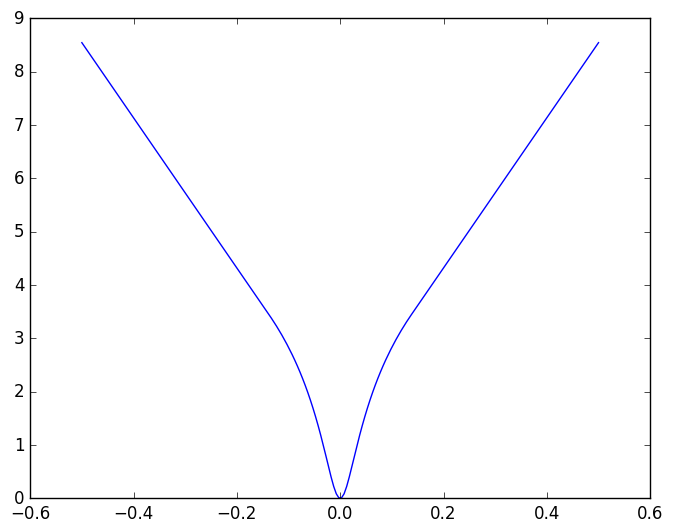

In [3]:
r = collect(linspace(-0.5,0.5,200));
θ = [5.5,0.025];
val = ρ(r,θ);
plot(r,val);

## Maximum Likelihood
* Normalization constant: $n_c([\kappa,\sigma]) = \sigma[1+2\kappa \arctan(\kappa)]/\kappa$
* Maximum likelihood:
$$\min_\alpha \frac{1}{mn}\rho(R;v) + \log[n_c(\theta)]$$

In [4]:
function objθ(θ,R)
    κ,σ = θ[1],θ[2]
    n = length(R)
    val = 0.0
    for i = 1:n
        abs(R[i]) > κ*σ ? val += 2.0*κ/(σ*(1.0+κ^2))*(abs(R[i])-κ*σ) + log(1.0+κ^2) :
                          val += log(1.0 + R[i]^2/σ^2)
    end
    val /= n
    val += log(σ*(1+2*κ*atan(κ))/κ)
    return val
end

objθ (generic function with 1 method)

In [5]:
function gradHθ(θ,R)
    n   = length(R)
    κ,σ = θ[1],θ[2]
    g   = zeros(2)
    H   = zeros(2,2)
    # gradient and hessian of the penalty
    for i = 1:n
        if abs(R[i]) > κ*σ
            # gradient
            g[1] += 2*(κ^2-1)*(κ*σ-abs(R[i]))/((1+κ^2)^2*σ)
            g[2] -= 2*κ*abs(R[i])/((1+κ^2)*σ^2)
            # hessian
            H[1,1] -= 2*(6*κ*abs(R[i])-2*κ^3*abs(R[i])+σ-6*κ^2*σ+κ^4*σ)/((1+κ^2)^3*σ)
            H[1,2] += 2*(κ^2-1)*abs(R[i])/((1+κ^2)^2*σ^2)
            H[2,1] += 2*(κ^2-1)*abs(R[i])/((1+κ^2)^2*σ^2)
            H[2,2] += 4*κ*abs(R[i])/((1+κ^2)*σ^3)
        else
            # gradient
            g[2] -= 2*R[i]^2/(R[i]^2*σ+σ^3)
            # hessian
            H[2,2] += 2*(R[i]^4+3*R[i]^2*σ^2)/(σ^2*(R[i]^2+σ^2)^2)
        end
    end
    scale!(g,1/n)
    scale!(H,1/n)
    # gradient and hessian of normalization constant
    # gradient
    g[1] += (κ^2-1)/(κ*(1+κ^2)*(1+2*κ*atan(κ)))
    g[2] += 1/σ
    # hessian
    H[1,1] += (1+6*κ^2-3*κ^4+(4*κ+8*κ^3-4*κ^5)*atan(κ))/(κ^2*(1+κ^2)^2*(1+2*κ*atan(κ))^2)
    H[2,2] -= 1/σ^2
    
    return g,H
end

gradHθ (generic function with 1 method)

In [8]:
tol = 1e-6;
itm = 50;
θ   = [5.5,0.025];
g,H = gradHθ(θ,R);
err = vecnorm(g);
noi = 0;
while err ≥ tol
    # update direction
#     noi ≥ 10 ? p = H \ g : p = g/norm(H);
    p = H \ g
    # line search
    η = 1.0;
    p[1] > θ[1] && (η = min(η,θ[1]/p[1]*0.99));
    p[2] > θ[2] && (η = min(η,θ[2]/p[2]*0.99));
    # update θ
    θ = θ - η*p;
    # update history
    g,H = gradHθ(θ,R);
    obj = objθ(θ,R);
    err = vecnorm(g);
    noi = noi + 1;
    noi%1==0 && @printf("iter %3d, obj %1.5e, err %1.5e\n",noi,obj,err)
    if noi ≥ itm
        break;
    end
end
@show θ

iter   1, obj -1.45270e+00, err 5.31802e-01
iter   2, obj -1.45325e+00, err 8.21385e-02
iter   3, obj -1.45328e+00, err 7.39323e-03
iter   4, obj -1.45328e+00, err 5.13549e-05
iter   5, obj -1.45328e+00, err 2.33560e-09
θ = [7.64608,0.022414]


2-element Array{Float64,1}:
 7.64608 
 0.022414

## Load Data

In [6]:
m,n = 20480, 202;  # size of matrix
mp, np = 128,160;   # size of one image

(128,160)

In [7]:
fid = open("results/R.bin","r")
Rt  = read(fid,Float64,m*n)
close(fid)
R = copy(Rt)
sort!(R);

In [10]:
function eCDF(x::Array{Float64,1},R::Array{Float64,1})
    sort!(x)
    n = length(x)
    m = length(R)
    v = zeros(n)
    j = 1
    for i = 1:n
        while j ≤ m && R[j] < x[i]
            j += 1
        end
        v[i] = (j-1)/m
    end
    return v
end

function ρCDF(x::Array{Float64,1},θ::Array{Float64,1})
    sort!(x)
    κ = θ[1]
    σ = θ[2]
    κσ = κ*σ
    n = length(x)
    val = zeros(n)
    for i = 1:n
        x[i] < -κσ ? val[i] = exp(2*κ*(x[i]+κσ)/(σ*(1+κ^2)))/(2+4*κ*atan(κ)) : 
        x[i] >  κσ ? val[i] = 1 - exp(2*κ*(-x[i]+κσ)/(σ*(1+κ^2)))/(2+4*κ*atan(κ)) : 
                     val[i] = 0.5 + κ*atan(x[i]/σ)/(1+2*κ*atan(κ))
    end
    return val
end

ρCDF (generic function with 1 method)

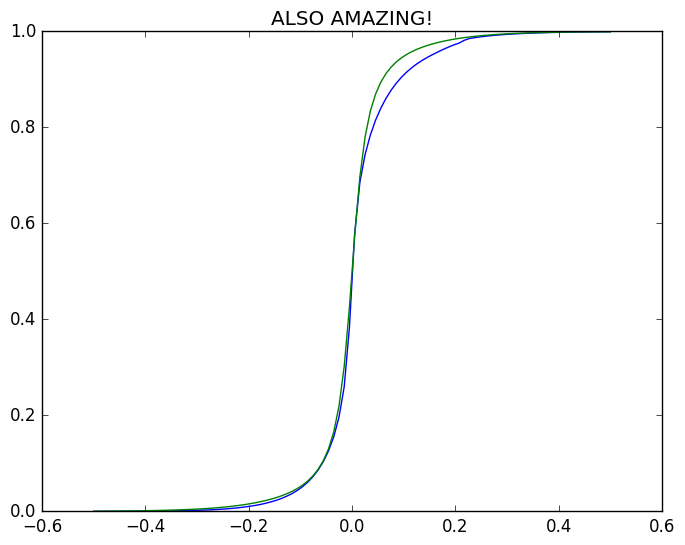

PyObject <matplotlib.text.Text object at 0x31ce5b210>

In [11]:
x = collect(linspace(-0.5,0.5,100));
v1 = eCDF(x,R);
v2 = ρCDF(x,θ);
plot(x,v1,"b")
plot(x,v2,"g")
title("ALSO AMAZING!")

## Recover S

In [12]:
κσ = θ[1]*θ[2];
S  = zeros(m,n);
r  = reshape(Rt,m,n);
for I in eachindex(S)
    r[I] >  κσ ? S[I] = r[I] - κσ :
    r[I] < -κσ ? S[I] = r[I] + κσ : continue;
end

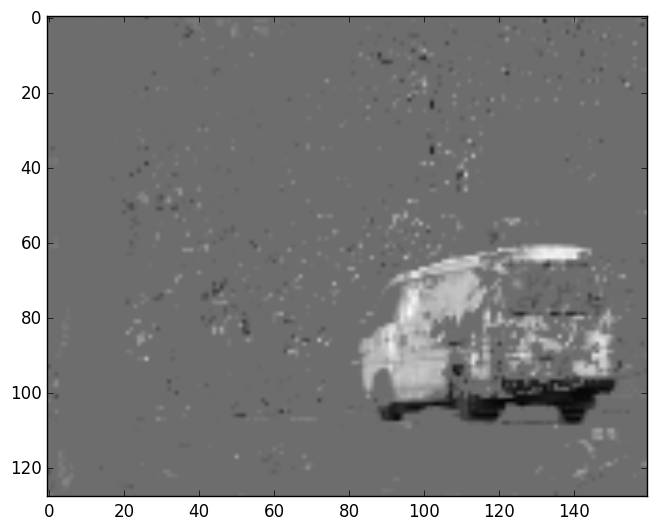

In [13]:
imshow(reshape(S[:,201],mp,np), cmap="gray");